### This module is to find optimal portfolio weights and back test the portfolio for investing objectives between risk and return expectations

> **Portfolio Optimisation for Swing Trading**
*  Identify optimal weights between portfolio of stocks for a given investment size Smart portfolio management that can reduce the volatility of a portfolio, and increase returns per unit of risk

* **These below are the steps**
  1. Get data from yfinance and define portfolio of stocks
  2. The stocks are selected by running stratagies 
  3. Build the correlation matrix and analyze covariance 
  4. Using the libraries back test for best porfolio and build process for custom portfolio
  5.  Manual check: build all possible combinations to buy : with limitations of not buying fractional shares.
  6. Manual check: distribution of returns, sharpe ratio. Draw the plots of Efficient frontier


In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
INVESTMENT = 2000 

TICKERS =['MSFT', 'AAPL', 'GOOG', 'AMZN']

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

### Get data from yahoo finance

In [ ]:
stocks_prices = pd.DataFrame({'A' : []})
stocks_info = pd.DataFrame({'A' : []})

for i,ticker in enumerate(TICKERS):
  print(i,ticker)
  yticker = yf.Ticker(ticker)
  
  # Get max history of prices
  historyPrices = yticker.history(period='max')
  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date
  
  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)

  # future growth 3 days  
  historyPrices['future_growth_3d'] = historyPrices['Close'].shift(-3) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  if stocks_prices.empty:
    stocks_prices = historyPrices
  else: 
    stocks_prices = pd.concat([stocks_prices,historyPrices], ignore_index=True)

0 MSFT
1 AAPL
2 GOOG
3 AMZN


In [ ]:
# Check one day
filter_last_date = stocks_prices.Date==stocks_prices.Date.max()
print(stocks_prices.Date.max())

2023-05-17


In [ ]:
stocks_prices[stocks_prices.Ticker=='AMZN'].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,Weekday,Date,growth_1d,growth_3d,growth_7d,growth_30d,growth_90d,growth_365d,future_growth_3d,volatility
31327,111.029999,113.279999,110.489998,112.180000,74924800,0.0,0.0,AMZN,2023,5,3,2023-05-11,1.018060,1.060002,1.082505,1.119002,1.335476,0.640195,1.010875,47.652520
31328,112.160004,112.639999,109.320000,110.260002,49810100,0.0,0.0,AMZN,2023,5,4,2023-05-12,0.982885,1.034140,1.063772,1.080980,1.284782,0.619165,1.047524,50.441799
31329,111.150002,112.290001,109.250000,111.199997,53011100,0.0,0.0,AMZN,2023,5,0,2023-05-15,1.008525,1.009166,1.069231,1.076580,1.306084,0.634148,NaN,54.061302
31330,111.050003,114.790001,111.050003,113.400002,71472900,0.0,0.0,AMZN,2023,5,1,2023-05-16,1.019784,1.010875,1.073254,1.107314,1.364293,0.658590,NaN,59.279439
31331,114.889999,115.830002,114.224998,115.500000,64621873,0.0,0.0,AMZN,2023,5,2,2023-05-17,1.018519,1.047524,1.091373,1.111111,1.341775,0.672027,NaN,66.524717


In [ ]:
df_pivot = stocks_prices.pivot('Date','Ticker','Close').reset_index()
df_pivot.tail(1)

<ipython-input-6-c020f7e1f640>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_pivot = stocks_prices.pivot('Date','Ticker','Close').reset_index()


Ticker,Date,AAPL,AMZN,GOOG,MSFT
10696,2023-05-17,172.690002,115.5,121.480003,314.0


In [ ]:
df_pivot.corr()

<ipython-input-7-197f5de02410>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_pivot.corr()


Ticker,AAPL,AMZN,GOOG,MSFT
Ticker,,,,
AAPL,1.000000,0.934021,0.969373,0.986579
AMZN,0.934021,1.000000,0.953854,0.953176
GOOG,0.969373,0.953854,1.000000,0.979066
MSFT,0.986579,0.953176,0.979066,1.000000


### Correlation among portfolio stocks

<ipython-input-8-e180225b5b66>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_pivot.corr()


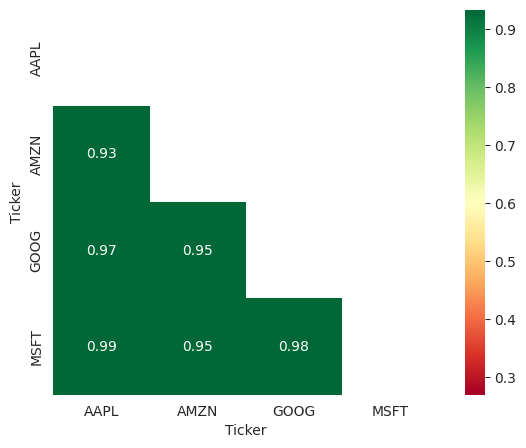

In [ ]:
corr = df_pivot.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True, cmap='RdYlGn')

In [ ]:
df_last_day_prices = stocks_prices[filter_last_date][['Ticker','Close']]
df_last_day_prices

,Ticker,Close
9370,MSFT,314.000000
20067,AAPL,172.690002
24786,GOOG,121.480003
31331,AMZN,115.500000


In [ ]:
df_last_day_prices.set_index('Ticker',inplace=True)

In [ ]:
df_last_day_prices.sort_values(by='Close', ascending=False)

,Close
Ticker,
MSFT,314.000000
AAPL,172.690002
GOOG,121.480003
AMZN,115.500000


In [ ]:
!pip install PyPortfolioOpt

import pypfopt
print(f'\n Library version: {pypfopt.__version__}')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.5 MB/s eta 0:00:00

 Library version: 1.5.5


In [ ]:
from pypfopt import risk_models
from pypfopt import plotting
sample_cov = risk_models.sample_cov(df_pivot.set_index('Date'), frequency=252)
sample_cov

Ticker,AAPL,AMZN,GOOG,MSFT
Ticker,,,,
AAPL,0.200263,0.078942,0.053307,0.063294
AMZN,0.078942,0.327347,0.061116,0.073316
GOOG,0.053307,0.061116,0.095275,0.047867
MSFT,0.063294,0.073316,0.047867,0.114431


### Covariance plot

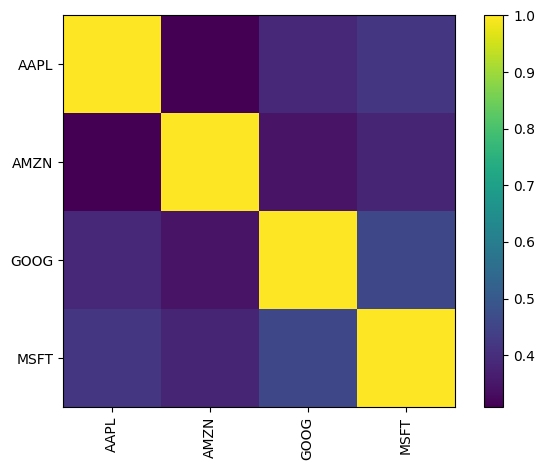

In [ ]:
plotting.plot_covariance(sample_cov, plot_correlation=True);

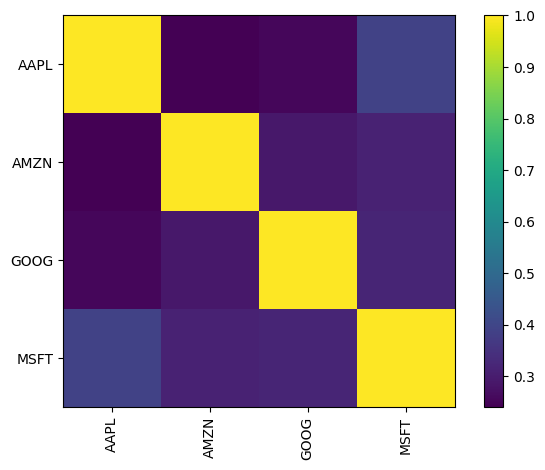

In [ ]:
S = risk_models.CovarianceShrinkage(df_pivot.set_index('Date')).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);

In [ ]:
S

Ticker,AAPL,AMZN,GOOG,MSFT
Ticker,,,,
AAPL,0.199842,0.048085,0.023403,0.055118
AMZN,0.048085,0.200018,0.026796,0.044500
GOOG,0.023403,0.026796,0.042666,0.020952
MSFT,0.055118,0.044500,0.020952,0.100492


### find weights using the library PyPortfolioOpt 

Expected returns from each stock: Ticker
AAPL    0.260233
AMZN    0.297293
GOOG    0.135118
MSFT    0.173661
Name: mkt, dtype: float64 

Portfolio weights for min volatility optimisation (lowest level of risk): {
    "AAPL": 0.04212,
    "AMZN": 0.0379,
    "GOOG": 0.74251,
    "MSFT": 0.17747
} 

Expected annual return: 15.3%
Annual volatility: 19.3%
Sharpe Ratio: 0.73
Portfolio performance: (0.1533746519877125, 0.19338937106963153, 0.7289679427984351) 

Portfolio weights for max Sharpe optimisation (highest return-per-risk): {
    "AAPL": 0.19152,
    "AMZN": 0.25843,
    "GOOG": 0.43052,
    "MSFT": 0.11953
} 

Expected annual return: 15.3%
Annual volatility: 19.3%
Sharpe Ratio: 0.73
Portfolio performance: (0.1533746519877125, 0.19338937106963153, 0.7289679427984351) 



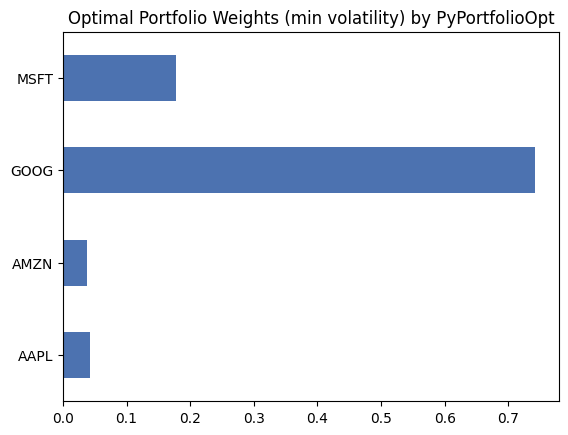

In [ ]:
from pypfopt import expected_returns
from pypfopt import EfficientFrontier
import json

mu = expected_returns.capm_return(df_pivot.set_index('Date'))
# Other options for the returns values: expected_returns.ema_historical_return(df_pivot.set_index('Date'))
# Other options for the returns values: expected_returns.mean_historical_return(df_pivot.set_index('Date'))
print(f'Expected returns from each stock: {mu} \n')

S = risk_models.CovarianceShrinkage(df_pivot.set_index('Date')).ledoit_wolf()

# Weights between 0 and 1 - we don't allow shorting
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef.min_volatility()
weights_min_volatility = ef.clean_weights()

print(f'Portfolio weights for min volatility optimisation (lowest level of risk): {json.dumps(weights_min_volatility, indent=4, sort_keys=True)} \n')
print(f'Portfolio performance: {ef.portfolio_performance(verbose=True, risk_free_rate=0.0381)} \n')
# Risk-free rate from https://www.cnbc.com/quotes/US10Y

pd.Series(weights_min_volatility).plot.barh(title = 'Optimal Portfolio Weights (min volatility) by PyPortfolioOpt');
ef2 = EfficientFrontier(mu, S, weight_bounds=(0, 1))
ef2.max_sharpe()
weights_max_sharpe = ef2.clean_weights()


print(f'Portfolio weights for max Sharpe optimisation (highest return-per-risk): {json.dumps(weights_max_sharpe, indent=4, sort_keys=True)} \n')
print(f'Portfolio performance: {ef.portfolio_performance(verbose=True, risk_free_rate=0.0124)} \n')

In [ ]:
expected_returns.np

<module 'numpy' from '/usr/local/lib/python3.10/dist-packages/numpy/__init__.py'>

In [ ]:
df_pivot.set_index('Date').iloc[-1]

Ticker
AAPL    172.690002
AMZN    115.500000
GOOG    121.480003
MSFT    314.000000
Name: 2023-05-17, dtype: float64

In [ ]:
from pypfopt import DiscreteAllocation

latest_prices = df_pivot.set_index('Date').iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights_max_sharpe, latest_prices, total_portfolio_value = INVESTMENT, short_ratio=0.0)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

Discrete allocation performed with $28.26 leftover


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1385: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'AAPL': 2, 'AMZN': 4, 'GOOG': 7, 'MSFT': 1}

In [ ]:
for key in alloc.keys():
  print(f' stock: {key}, value = {alloc[key]*latest_prices[key]/INVESTMENT}')

 stock: AAPL, value = 0.17269000244140625
 stock: AMZN, value = 0.231
 stock: GOOG, value = 0.42518001174926756
 stock: MSFT, value = 0.157


### Manual optimisation: OrderedDict in Python and brute force to generate all possible portfolios 
(discrete values for stocks, no short selling)

In [ ]:
from collections import OrderedDict

In [ ]:
dict_stocks_prices =  OrderedDict(df_last_day_prices.sort_values(by='Close', ascending=False)['Close'].to_dict())
dict_stocks_prices

OrderedDict([('MSFT', 314.0),
             ('AAPL', 172.69000244140625),
             ('GOOG', 121.4800033569336),
             ('AMZN', 115.5)])

In [ ]:
for key in dict_stocks_prices.keys():
  print(f' STOCK = {key}, LAST PRICE = {np.round(dict_stocks_prices[key])}, MAX_COUNT = {np.trunc(INVESTMENT/dict_stocks_prices[key])}')

 STOCK = MSFT, LAST PRICE = 314.0, MAX_COUNT = 6.0
 STOCK = AAPL, LAST PRICE = 173.0, MAX_COUNT = 11.0
 STOCK = GOOG, LAST PRICE = 121.0, MAX_COUNT = 16.0
 STOCK = AMZN, LAST PRICE = 116.0, MAX_COUNT = 17.0


In [ ]:
copy_dict = dict_stocks_prices.copy() 
copy_dict

OrderedDict([('MSFT', 314.0),
             ('AAPL', 172.69000244140625),
             ('GOOG', 121.4800033569336),
             ('AMZN', 115.5)])

In [ ]:
def first(s):
    '''Return the first element from an ordered collection
       or an arbitrary element from an unordered collection.
       Raise StopIteration if the collection is empty.
    '''
    return next(iter(s))

In [ ]:
item = first(copy_dict)
elem = copy_dict.pop(item)

In [ ]:
print(item, elem)
print(copy_dict)
print(dict_stocks_prices)

MSFT 314.0
OrderedDict([('AAPL', 172.69000244140625), ('GOOG', 121.4800033569336), ('AMZN', 115.5)])
OrderedDict([('MSFT', 314.0), ('AAPL', 172.69000244140625), ('GOOG', 121.4800033569336), ('AMZN', 115.5)])


In [ ]:
# Get all options for one-stock investment portfolio (not nessesary spending full sum of money)
def invest_one_stock(investment, dict_stocks_prices):
  selected_stock = first(dict_stocks_prices)
  price = dict_stocks_prices.pop(selected_stock)
  max_count = np.trunc(investment / price).astype(int)
  print(f'STOCK = {selected_stock}, PRICE = {price}, MAX_TO_BUY = {max_count}')
  
  all_options = []
  print(type(max_count))
  print(list(range(0, max_count+1)) )
  
  for count in range(0, int(max_count)+1):
    result = dict({selected_stock:count})
    print(f'portfolio = {result}, remaining_to_invest = {investment-count*price}')
    all_options.append(result)
  return all_options  

In [ ]:
portfolios_one_stock = invest_one_stock(INVESTMENT, dict_stocks_prices.copy())

STOCK = MSFT, PRICE = 314.0, MAX_TO_BUY = 6
<class 'numpy.int64'>
[0, 1, 2, 3, 4, 5, 6]
portfolio = {'MSFT': 0}, remaining_to_invest = 2000.0
portfolio = {'MSFT': 1}, remaining_to_invest = 1686.0
portfolio = {'MSFT': 2}, remaining_to_invest = 1372.0
portfolio = {'MSFT': 3}, remaining_to_invest = 1058.0
portfolio = {'MSFT': 4}, remaining_to_invest = 744.0
portfolio = {'MSFT': 5}, remaining_to_invest = 430.0
portfolio = {'MSFT': 6}, remaining_to_invest = 116.0


In [ ]:
# all options for a partial portfolio investment
portfolios_one_stock

[{'MSFT': 0},
 {'MSFT': 1},
 {'MSFT': 2},
 {'MSFT': 3},
 {'MSFT': 4},
 {'MSFT': 5},
 {'MSFT': 6}]

In [ ]:
portfolios_one_stock[0].update({'ANOTHER_STOCK':3})

In [ ]:
portfolios_one_stock

[{'MSFT': 0, 'ANOTHER_STOCK': 3},
 {'MSFT': 1},
 {'MSFT': 2},
 {'MSFT': 3},
 {'MSFT': 4},
 {'MSFT': 5},
 {'MSFT': 6}]

In [ ]:
def generate_all_portfolios(investment, dict_stocks_prices):
  
  # DEBUG: 
  # print(f'This call: invest_all_stocks({investment}, {dict_stocks_prices})')
  
  # if no stocks to invest ==> return zero portfolio
  if not dict_stocks_prices:
    return []

  # we have at least one stock to invest to ==> try to find min and max investment into that stock
  selected_stock = first(dict_stocks_prices)
  price = dict_stocks_prices.pop(selected_stock)
  max_count = np.trunc(investment / price).astype(int)
 
  # if can't buy a current stock ==> try to buy a next one (which is a lower price) 
  if max_count ==0:
    return generate_all_portfolios(investment, dict_stocks_prices.copy())

  # if no other stocks left to buy ==> spend all money on the current stock and return 1 option in array: full stock investment
  if len(dict_stocks_prices.keys())==0:
    return [{selected_stock:max_count}]  
  
  all_options = []
  for count in range(0, max_count+1):
    result = dict({selected_stock:count})
    other_portfolios = generate_all_portfolios(investment - count*price, dict_stocks_prices.copy())
    for option in other_portfolios:
      result.update(option)
      all_options.append(dict(result))

  # DEBUG:
  # print(f'all options={all_options}')    
  return all_options  

### Generate All portfolios for a given set of stocks and the investment 

In [ ]:
all_portfolios = generate_all_portfolios(INVESTMENT, dict_stocks_prices.copy())

In [ ]:
import random

In [ ]:
for elem in all_portfolios[-1]:
  print(f' elem = {elem}, price = {dict_stocks_prices[elem]}')

 elem = MSFT, price = 314.0
 elem = AMZN, price = 115.5


In [ ]:
print(f'Found combinations of portfolios: {len(all_portfolios)}')
for ii in range(1, 6, 1):
    random_portfolio = random.choice(all_portfolios)
    random_portfolio_price = 0
    for elem in random_portfolio:
      random_portfolio_price += random_portfolio[elem] * dict_stocks_prices[elem]
    print(f'Random portfolio {ii}: {random_portfolio} with total price {np.round(random_portfolio_price,1)}')

Found combinations of portfolios: 263
Random portfolio 1: {'MSFT': 1, 'AAPL': 0, 'GOOG': 12, 'AMZN': 1} with total price 1887.3
Random portfolio 2: {'MSFT': 1, 'AAPL': 2, 'GOOG': 0, 'AMZN': 11} with total price 1929.9
Random portfolio 3: {'MSFT': 1, 'AAPL': 0, 'GOOG': 4, 'AMZN': 10} with total price 1954.9
Random portfolio 4: {'MSFT': 4, 'AAPL': 1, 'GOOG': 1, 'AMZN': 3} with total price 1896.7
Random portfolio 5: {'MSFT': 0, 'AAPL': 4, 'GOOG': 9, 'AMZN': 1} with total price 1899.6


### Build performance metrics (risk, return, risk/return, CVAr, Max_drawdown) for a given portfolio

In [ ]:
SELECTED_PORTFOLIO = {'AAPL': 1, 'GOOG': 1, 'AMZN': 1, 'MSFT': 1 }

SELECTED_PORTFOLIO

{'AAPL': 1, 'GOOG': 1, 'AMZN': 1, 'MSFT': 1}

In [ ]:
stocks_prices["Date"] = pd.to_datetime(stocks_prices.Date)

In [ ]:
one_day = stocks_prices[stocks_prices.Date == '2021-06-08'][['Date','Ticker','Close']].set_index('Date')

In [ ]:
one_day

,Ticker,Close
Date,,
2021-06-08,MSFT,248.668304
2021-06-08,AAPL,125.271996
2021-06-08,GOOG,124.142502
2021-06-08,AMZN,163.205505


In [ ]:
one_day

,Ticker,Close
Date,,
2021-06-08,MSFT,248.668304
2021-06-08,AAPL,125.271996
2021-06-08,GOOG,124.142502
2021-06-08,AMZN,163.205505


In [ ]:
one_day['qty']= one_day.Ticker.map(SELECTED_PORTFOLIO)

In [ ]:
portfolio_value_one_day = np.sum(one_day.Close * one_day.qty)
portfolio_value_one_day

661.2883071899414

In [ ]:
all_days = stocks_prices[['Date','Ticker','Close']].set_index('Date')
all_days['qty'] = all_days.Ticker.map(SELECTED_PORTFOLIO)
all_days['price'] = all_days.qty * all_days.Close

In [ ]:
portfolio_value_daily = all_days[all_days.index>='2018-01-01'].groupby('Date')['price'].sum()
# daily_investment = pd.pivot_table(all_stocks_portfolio, values='Close', index=['Ticker'], columns=['Close'], aggfunc=np.sum)
portfolio_value_daily

Date
2018-01-02    234.270241
2018-01-03    236.272396
2018-01-04    237.641430
2018-01-05    240.891895
2018-01-08    241.944374
                 ...    
2023-05-11    712.699997
2023-05-12    709.720009
2023-05-15    709.689995
2023-05-16    717.299995
2023-05-17    723.670006
Name: price, Length: 1353, dtype: float64

In [ ]:
df_portfolio_value_daily = pd.DataFrame(portfolio_value_daily)

<Axes: title={'center': "Value of a portfolio {'AAPL': 1, 'GOOG': 1, 'AMZN': 1, 'MSFT': 1} over time"}, xlabel='Date'>

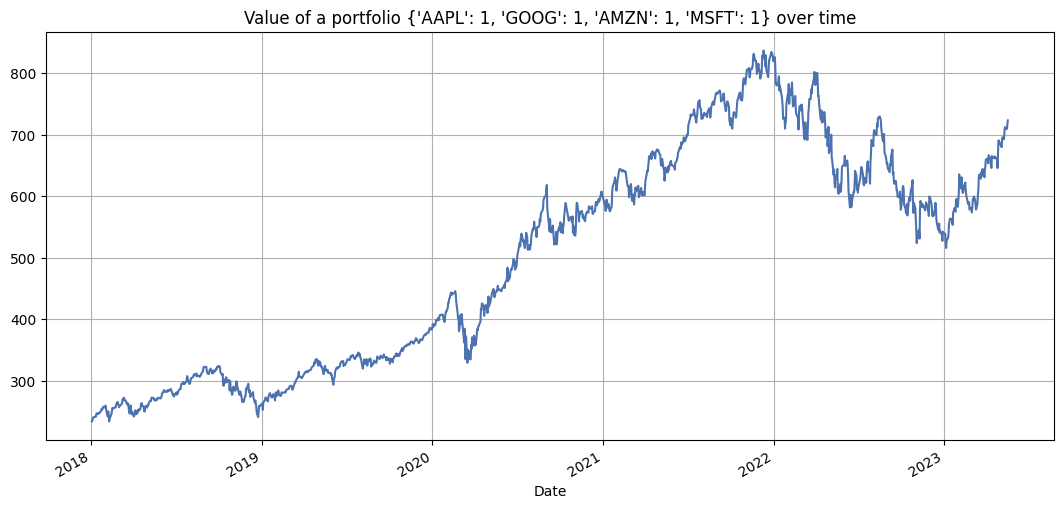

In [ ]:
df_portfolio_value_daily.price.plot.line(title=f"Value of a portfolio {SELECTED_PORTFOLIO} over time", grid = True, figsize=(13,6))

In [ ]:
# Interactive graph - you can zoom in
fig = px.line(df_portfolio_value_daily, x=df_portfolio_value_daily.index, y="price", title=f'Value of a portfolio {SELECTED_PORTFOLIO} over time -- DYNAMIC')
fig.show()


### Back Testing portfolio

In [ ]:
!pip install portfolio-backtest

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Insert the directory
# Right click on SwingTrader folder from shared files and select create short cut to add at My Drive
import sys
sys.path.insert(0,'/content/drive/My Drive/SwingTrader')

In [ ]:
from portfolio_backtest import Backtest

Backtest(tickers=["MSFT", "AAPL", "GOOG","AMZN"]).run()

[*********************100%***********************]  4 of 4 completed


[{'portfolio': 'Tangency Portfolio',
  'tickers': {'AAPL': 0.8046, 'AMZN': 0.05434, 'GOOG': 0.14107, 'MSFT': 0.0},
  'Expected annual return': '34.5%',
  'Annual volatility': '30.3%',
  'Sharpe Ratio': '1.07',
  'Conditional Value at Risk': '',
  'Cumulative Return': '29748.8%'},
 {'portfolio': 'Minimum Variance Portfolio',
  'tickers': {'AAPL': 0.19668,
   'AMZN': 0.04971,
   'GOOG': 0.2586,
   'MSFT': 0.49502},
  'Expected annual return': '22.8%',
  'Annual volatility': '24.8%',
  'Sharpe Ratio': '0.84',
  'Conditional Value at Risk': '',
  'Cumulative Return': '5827.3%'},
 {'portfolio': 'Hierarchical Risk Parity Portfolio',
  'tickers': {'AAPL': 0.23996,
   'AMZN': 0.17687,
   'GOOG': 0.25715,
   'MSFT': 0.32602},
  'Expected annual return': '26.9%',
  'Annual volatility': '25.3%',
  'Sharpe Ratio': '0.98',
  'Conditional Value at Risk': '',
  'Cumulative Return': '8361.5%'},
 {'portfolio': 'Minimum CVaR Portfolio',
  'tickers': {'AAPL': 0.1933,
   'AMZN': 0.05996,
   'GOOG': 0.2577

In [ ]:
from IPython.display import HTML
from IPython.display import display
from IPython.display import Image

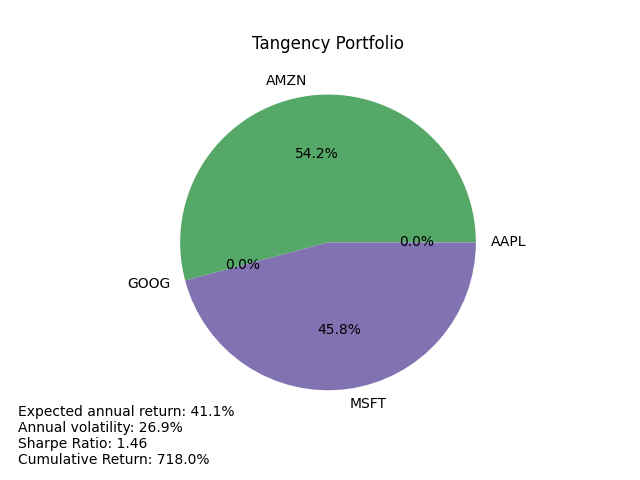

In [ ]:
display(Image(filename='/content/drive/My Drive/SwingTrader/data/tangency-portfolio.png'))

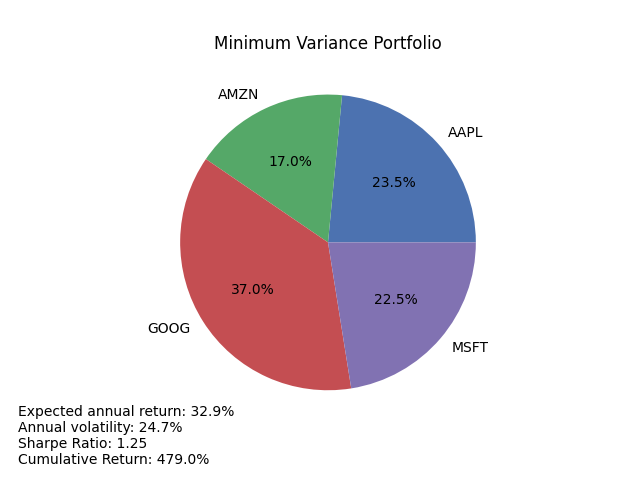

In [ ]:
display(Image(filename='/content/drive/My Drive/SwingTrader/data/minimum-variance-portfolio.png'))

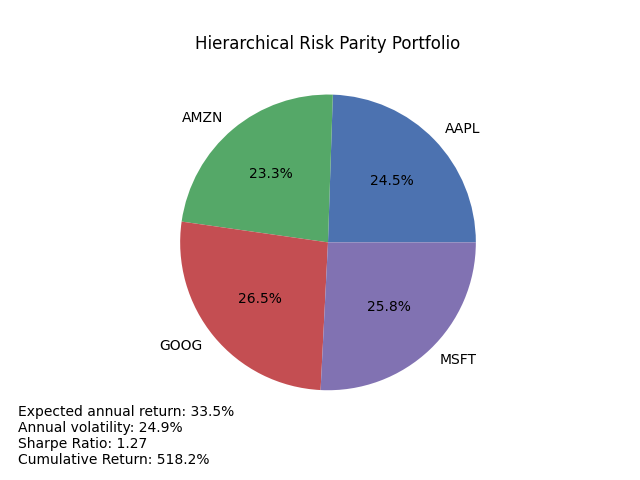

In [ ]:
display(Image(filename='/content/drive/My Drive/SwingTrader/data/hierarchical-risk-parity-portfolio.png'))

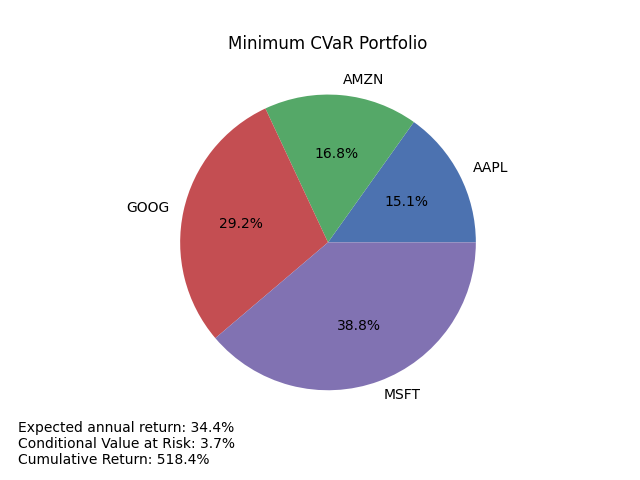

In [ ]:
display(Image(filename='/content/drive/My Drive/SwingTrader/data/minimum-cvar-portfolio.png'))

### Build a custom portfolio 

In [ ]:
!pip install testfolio -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import testfolio as tsf
#customer weights 
allocation_1 = {
    'AAPL': 0.6,
    'GOOG': 0.2,
    'AMZN': 0.1,
    'MSFT': 0.1
}

backtest_1 = tsf.Backtest(allocation_1, rebalance='q', name='0.6AAPL-0.2GOOG-0.1AMZN-0.1MSFT')
print(backtest_1)

------------------- Metrics -------------------
Name: 0.6AAPL-0.2GOOG-0.1AMZN-0.1MSFT
Allocation: {'AAPL': 0.6, 'GOOG': 0.2, 'AMZN': 0.1, 'MSFT': 0.1}
Starting Value: $1000.00
Ending Value: $207318.19
Start Date: 2004-08-19
End Date: 2023-05-17
CAGR: 32.90%
Maximum Drawdown: -58.81%
STD (annualized): 27.71%
Sharpe Ratio: 1.12
Sortino Ratio: 1.65
Market Correlation: 0.75
-----------------------------------------------



In [ ]:
ALIAS_TO_TICKER = {
    'S&P 500': 'VFINX',
    'Long Term Treasury': 'VUSTX',
    'Total US Bond Market': 'VBMFX',
    'Total US Stock Market': 'VTSMX',
    'Total Intl Stock Market': 'VGTSX',
    'Gold': 'GC=F',
    'Intermediate Term Treasury': 'IEF',
    'Short Term Treasury': 'VFISX',
    'REIT': 'VGSIX',
    'US Small Cap': 'NAESX',
    'US Mid Cap': 'VMCIX'
}

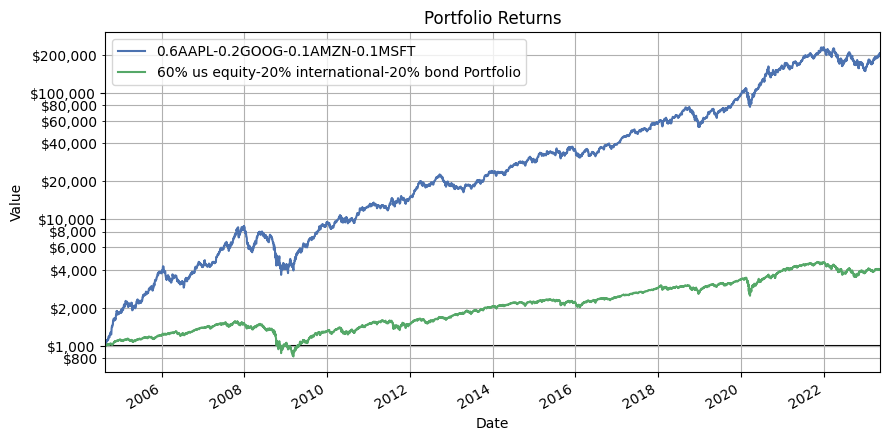

In [ ]:
allocation_2 = {
    'Total US Stock Market': 0.60,
    'Total Intl Stock Market': 0.20,
    'Total US Bond Market': 0.20
}

backtest_2 = tsf.Backtest(allocation_2, rebalance='q', name='60% us equity-20% international-20% bond Portfolio')

tsf.graph_return(backtest_1, backtest_2, start_val=1000, logarithmic=True)


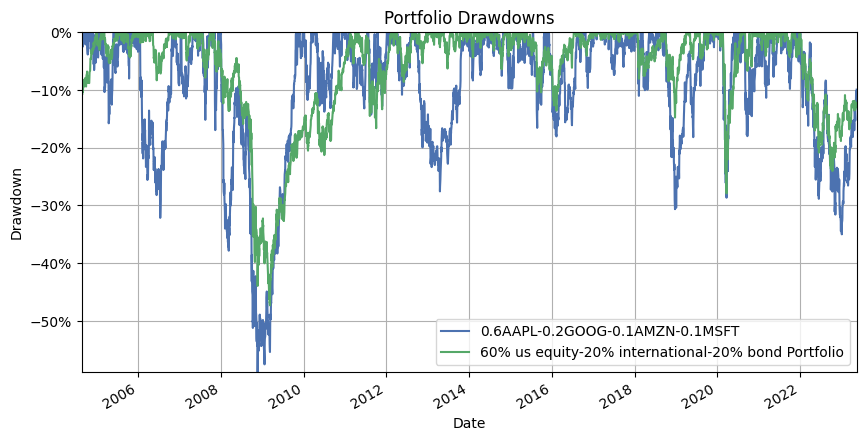

In [ ]:
tsf.graph_drawdown(backtest_1, backtest_2)

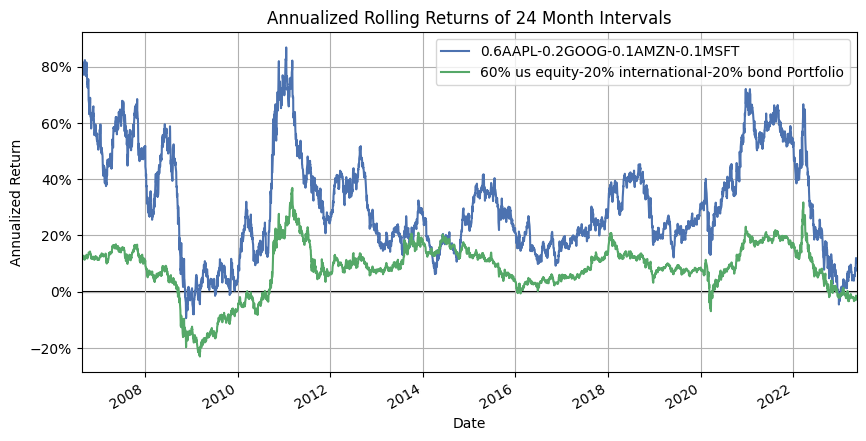

In [ ]:
tsf.graph_rolling_returns(backtest_1, backtest_2, interval=24)